Image Colorization
======
We show image colorization as an example of an image-to-image application of CNNs. For practicality, we only experiment on CIFAR. A lot of approaches can be taken to improve the results over the straight-forward implementation in this notebook:

* [*Let there be Color!*](http://hi.cs.waseda.ac.jp/~iizuka/projects/colorization/en/), Iizuka et al., 2016
* [*Colorful Image Colorization*](http://richzhang.github.io/colorization/), Zhang et al. 2016
* [*Learning Representations for Automatic Colorization*](https://arxiv.org/abs/1603.06668), Larsson et al., 2016
* [*Real-Time User-Guided Image Colorization with Learned Deep Priors*](https://richzhang.github.io/ideepcolor/), Zhang et al. 2017


In [1]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_epochs = 50
batch_size = 512
learning_rate = 1e-3
use_gpu = True

CIFAR Data Loading
-------------------

The CIFAR dataset contains 60000 32x32 colour images, split into 50000 training images and 10000 test images. Each image is labeled as one of either 10 (CIFAR10) or 100 (CIFAR100) classes, but we are not using the labels here.

In [22]:
import numpy as np
from skimage import color

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Color Regressor Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [4]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) # out: 2 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x

cnet = ColorNet()
if use_gpu:
    cnet = cnet.cuda()

num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 773698


Train Color Regressor
--------


In [5]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)

# set to training mode
cnet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for lab_batch, _ in train_dataloader:
        
        lab_batch = Variable(lab_batch)
        if use_gpu:
            lab_batch = lab_batch.cuda()
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
        
        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.data[0]
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 181.322360
Epoch [2 / 50] average reconstruction error: 160.909647
Epoch [3 / 50] average reconstruction error: 156.191648
Epoch [4 / 50] average reconstruction error: 152.951241
Epoch [5 / 50] average reconstruction error: 150.103660
Epoch [6 / 50] average reconstruction error: 147.112673
Epoch [7 / 50] average reconstruction error: 142.795780
Epoch [8 / 50] average reconstruction error: 137.928212
Epoch [9 / 50] average reconstruction error: 132.620762
Epoch [10 / 50] average reconstruction error: 126.942215
Epoch [11 / 50] average reconstruction error: 119.376692
Epoch [12 / 50] average reconstruction error: 110.640589
Epoch [13 / 50] average reconstruction error: 103.866985
Epoch [14 / 50] average reconstruction error: 98.371799
Epoch [15 / 50] average reconstruction error: 93.199795
Epoch [16 / 50] average reconstruction error: 88.219029
Epoch [17 / 50] average reconstruction error: 84.499491
Epoch [18 / 50] average reconst

Plot Training Curves
--------------------

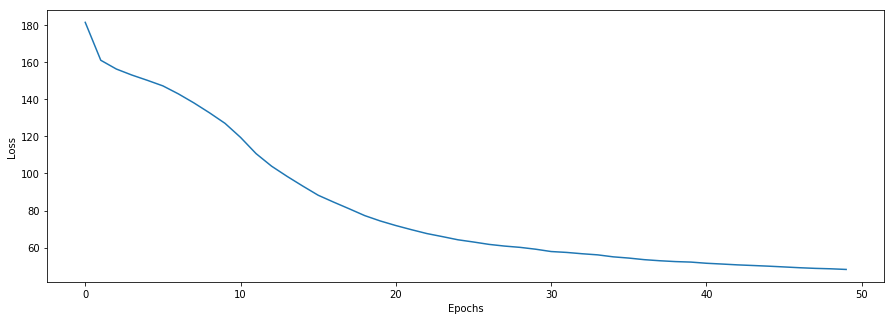

In [6]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Alternatively: Load Pre-Trained Color Regressor
-----------------------------

In [7]:
cnet.load_state_dict(torch.load('./pretrained/color_net.pth'))

# this is how the model parameters can be saved:
# torch.save(cnet.state_dict(), './pretrained/my_color_net.pth')

Evaluate on the Test Set
----------------------------

In [8]:
# set to evaluation mode
cnet.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, _ in test_dataloader:

    lab_batch = Variable(lab_batch)
    if use_gpu:
        lab_batch = lab_batch.cuda()

    # apply the color net to the luminance component of the Lab images
    # to get the color (ab) components
    predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])

    # loss is the L2 error to the actual color (ab) components
    loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])

    test_loss_avg += loss.data[0]
    num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 47.835767


Show Random Re-Colored Images from the Test Set
-------------------------------------------------
Since our network is relatively simple and small, it still makes a lot of errors, but things like sky, water and background vegetation usually get a plausible color. Correctly coloring details on various objects would require a network with more parameters and for really good results at higher resolutions, some additional tricks need to be applied, as described in the papers linked at the beginning.

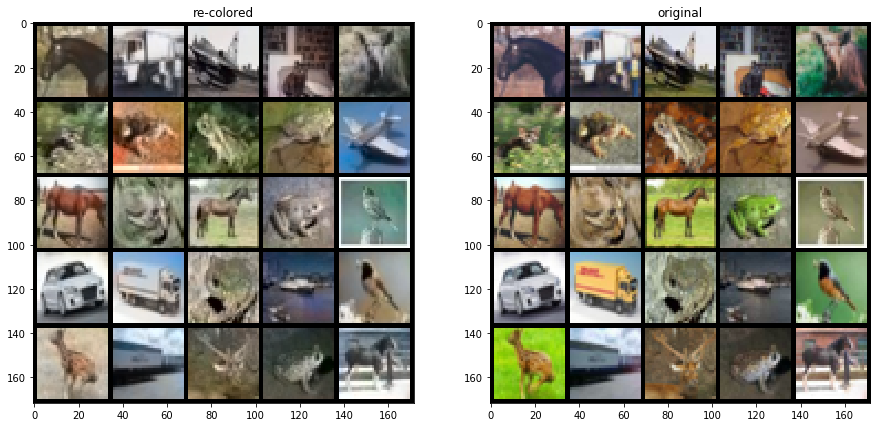

In [24]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

# pick a random subset of images from the test set
image_inds = np.random.choice(len(test_dataset), 25, replace=False)
lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])

lab_batch = Variable(lab_batch)
if use_gpu:
    lab_batch = lab_batch.cuda()
    
# predict colors (ab channels)
predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

if use_gpu:
    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()
lab_batch = lab_batch.data
predicted_lab_batch = predicted_lab_batch.data

# convert to rgb
rgb_batch = []
predicted_rgb_batch = []
for i in range(lab_batch.size(0)):
    rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
    rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
    predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
    predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))
   
# plot images
fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
ax[0].title.set_text('re-colored')
ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
ax[1].title.set_text('original')
plt.show()
